# Objekte mit maschinellem Lernen zusammenführen

Der `ObjectMerger` ist ein Random Forest Classifier, der Teil der [apoc-Bibliothek](https://github.com/haesleinhuepf/apoc) ist und lernen kann, welche Beschriftungen zusammengeführt werden sollen und welche nicht. Er ermöglicht die Nachbearbeitung von Beschriftungsbildern, nachdem Objekte (absichtlich oder unabsichtlich) übersegmentiert wurden.

In [1]:
import apoc
from skimage.io import imread, imshow
import pyclesperanto_prototype as cle
import numpy as np

Ein häufiges Beispiel kann von einem Bild abgeleitet werden, das Intensitäten in Zellmembranen zeigt.

cl.OCLArray([[4496., 5212., 6863., ..., 2917., 2680., 2642.],
       [4533., 5146., 7555., ..., 2843., 2857., 2748.],
       [4640., 6082., 8452., ..., 3372., 3039., 3128.],
       ...,
       [1339., 1403., 1359., ..., 4458., 4314., 4795.],
       [1473., 1560., 1622., ..., 3967., 4531., 4204.],
       [1380., 1368., 1649., ..., 3091., 3558., 3682.]], dtype=float32)
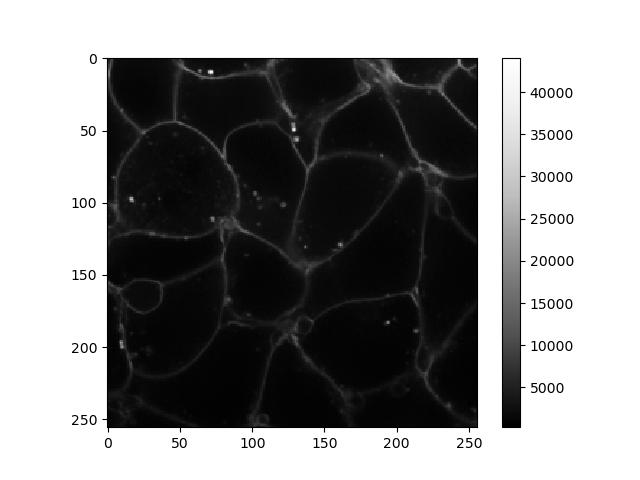
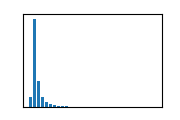

In [2]:
image = imread('../../data/membrane2d.tif')
cle.asarray(image)

Da die Membranen je nach Region im Bild unterschiedliche Intensitäten aufweisen, müssen wir dies zunächst korrigieren.

cl.OCLArray([[0.8514066 , 1.0200942 , 1.3921092 , ..., 0.6749894 , 0.6340478 ,
        0.6390664 ],
       [0.8397066 , 0.9866097 , 1.5033678 , ..., 0.6544611 , 0.6719634 ,
        0.6603491 ],
       [0.8410301 , 1.1425375 , 1.6502894 , ..., 0.7734034 , 0.7116847 ,
        0.747907  ],
       ...,
       [0.6833182 , 0.70865285, 0.6797715 , ..., 1.5903093 , 1.5137495 ,
        1.6566108 ],
       [0.7665792 , 0.8030892 , 0.8264799 , ..., 1.3939476 , 1.5649658 ,
        1.4287568 ],
       [0.73148733, 0.71694326, 0.85501015, ..., 1.0721965 , 1.2123575 ,
        1.2338016 ]], dtype=float32)
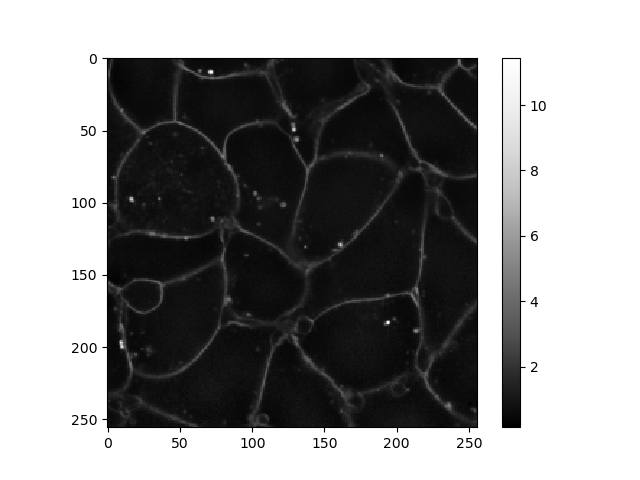
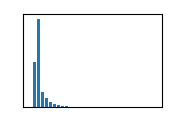

In [3]:
background_subtracted = cle.divide_by_gaussian_background(image, sigma_x=10, sigma_y=10)
background_subtracted

Aus technischen Gründen wird auch empfohlen, das Intensitätsbild in ein Bild vom Typ Integer umzuwandeln. Daher kann eine Normalisierung erforderlich sein. Es ist wichtig, dass Bilder, die für das Training verwendet werden, und Bilder, die für die Vorhersage verwendet werden, Intensitäten im gleichen Bereich haben.

cl.OCLArray([[ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       ...,
       [49, 49, 49, ..., 54, 54, 54],
       [49, 49, 49, ..., 54, 54, 54],
       [49, 49, 49, ..., 54, 54, 54]], dtype=uint32)
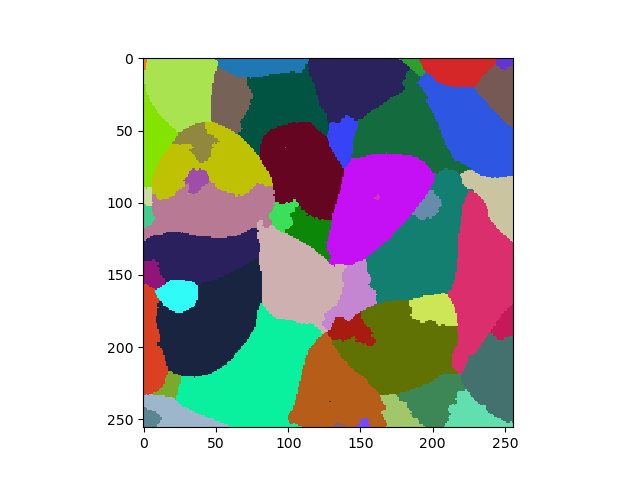

In [4]:
oversegmented = imread("../../data/membrane2d_oversegmented.tif")
cle.asarray(oversegmented).astype(np.uint32)

Eine Annotation dient dazu, dem Algorithmus mitzuteilen, welche segmentierten Objekte zusammengeführt werden sollen und welche nicht.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
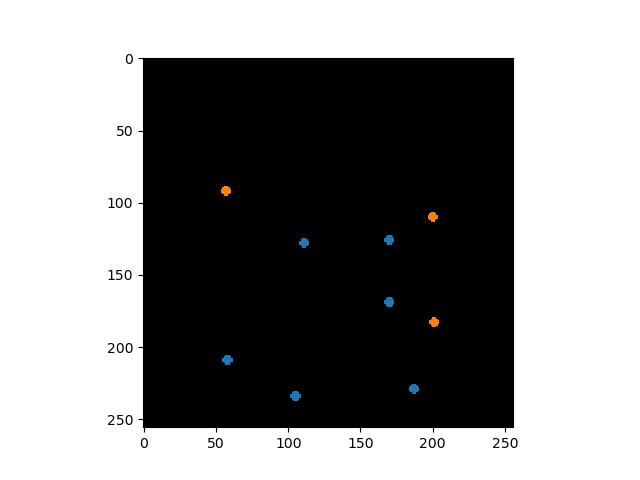

In [5]:
annotation = imread("../../data/membrane2d_merge_annotation.tif")
cle.asarray(annotation).astype(np.uint32)

Zu Visualisierungszwecken können wir die Annotation mit dem Membranbild überlagern.

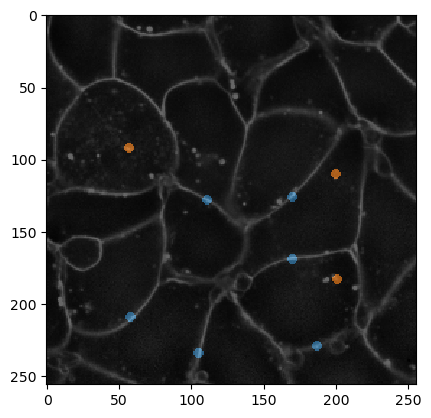

In [6]:
cle.imshow(background_subtracted, max_display_intensity=4, continue_drawing=True)
cle.imshow(annotation, alpha=0.6, labels=True)

Um genauer zu zeigen, was annotiert werden muss, überlagern wir auch das Label-Edge-Bild und die Annotation. Beachten Sie, dass die Kanten, die nicht zusammengeführt werden sollen, kleine Punkte sind, die immer sorgfältig nur zwei Objekte annotieren (die nicht zusammengeführt werden sollen).

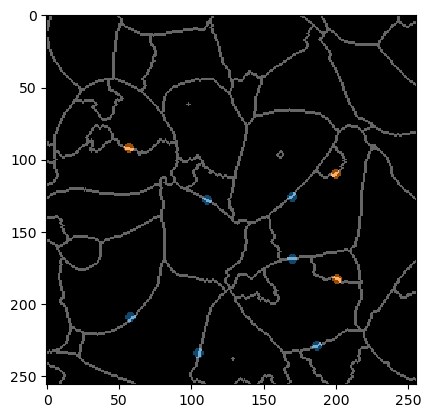

In [7]:
cle.imshow(cle.detect_label_edges(oversegmented), continue_drawing=True)
cle.imshow(annotation, alpha=0.6, labels=True)

## Training des Mergers

Der `LabelMerger` kann mit drei Merkmalen trainiert werden:
* `touch_portion`: Der relative Anteil, den ein Objekt ein anderes berührt. Z.B. in einem symmetrischen, wabenartigen Gewebe haben benachbarte Zellen einen Berührungsanteil von `1/6` zueinander.
* `touch_count`: Die Anzahl der Pixel, an denen sich Objekte berühren. Wenn Sie diesen Parameter verwenden, stellen Sie sicher, dass Bilder, die für Training und Vorhersage verwendet werden, die gleiche Voxelgröße haben.
* `mean_touch_intensity`: Die durchschnittliche Intensität zwischen sich berührenden Objekten. Wenn eine Zelle übersegmentiert ist, werden mehrere Objekte innerhalb dieser Zelle gefunden. Der Bereich, in dem sich diese Objekte berühren, hat eine geringere Intensität als der Bereich, in dem sich zwei Zellen berühren. So können sie unterschieden werden. Die Normalisierung des Bildes wie oben gezeigt ist entscheidend.
* `centroid_distance`: Der Abstand (in Pixeln oder Voxeln) zwischen den Schwerpunkten der markierten Objekte.

Hinweis: Die meisten Merkmale werden empfohlen, nur in isotropen Bildern verwendet zu werden.

In [8]:
feature_definition = "touch_portion mean_touch_intensity"

classifier_filename = "label_merger.cl"

apoc.erase_classifier(classifier_filename)
classifier = apoc.ObjectMerger(opencl_filename=classifier_filename)

classifier.train(features=feature_definition,
                 labels=oversegmented,
                 sparse_annotation=annotation,
                 image=background_subtracted) 

cl.OCLArray([[ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       ...,
       [28, 28, 28, ..., 31, 31, 31],
       [28, 28, 28, ..., 31, 31, 31],
       [28, 28, 28, ..., 31, 31, 31]], dtype=uint32)
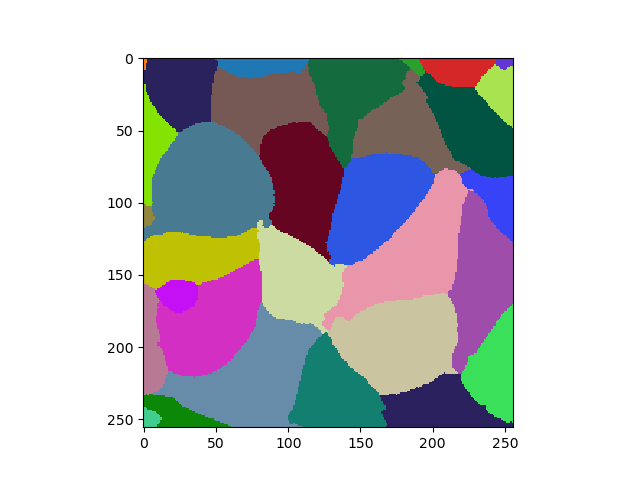

In [9]:
merged_labels = classifier.predict(labels=oversegmented, image=background_subtracted)
merged_labels